In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
from scipy.signal import correlate, correlation_lags
import statsmodels.api as sm
from scipy.stats import pearsonr

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Errata: Sampling in San Diego is proportional to case counts in each zipcode
To assess the quality of our genomic surveillance, we calculate the correlation between the number of sequences collected from a zipcode, and the reported number of cases in that zipcode. Stratifying by HHSA region, we should that there is a strong correlation indicating a less sampling bias.

In [2]:
md = pd.read_csv(
    "https://raw.githubusercontent.com/andersen-lab/HCoV-19-Genomics/master/metadata.csv",
    usecols=["ID", "gisaid_accession", "collection_date", "location", "zipcode"],
    dtype={"zipcode" : str },
    parse_dates=["collection_date"]
)
md["zipcode"] = md["zipcode"].apply( lambda x: str( x ).split( "-" )[0] )
md["zipcode"] = md["zipcode"].str.replace(".0", "", regex=False )
md["gisaid_accession"] = md["gisaid_accession"].str.strip()

zips = pd.read_csv(
    "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/data/SanDiegoZIP_region.csv",
    dtype={"ZIP" : str}
)

md = md.merge( zips, left_on="zipcode", right_on="ZIP", how="left" )

,accession_id,date_collected,epiweek,ss_location
0,EPI_ISL_11794612,2022-01-23,2022-01-23,Aguascalientes
1,EPI_ISL_9431233,2022-01-03,2022-01-02,Aguascalientes
2,EPI_ISL_6227487,2021-10-20,2021-10-17,Aguascalientes
3,EPI_ISL_11013529,2022-03-01,2022-02-27,Aguascalientes
4,EPI_ISL_4199516,2021-08-03,2021-08-01,Aguascalientes


In [37]:
selected = pd.read_csv( "../analyses/generate-california-border-tree/selected_2022-08-29.csv", usecols=["accession_id", "date_collected", "epiweek", "ss_location"], parse_dates=["date_collected", "epiweek"] )
selected.head()

test = selected.merge( md[["gisaid_accession","zipcode", "Region"]], left_on="accession_id", right_on="gisaid_accession", how="inner" )
test = test.groupby( ["Region", "epiweek"] )["ss_location"].agg( "count" )
test.name = "sequences"

cases = pd.read_csv( "https://raw.githubusercontent.com/watronfire/lone_pine/master/resources/cases.csv", usecols=["updatedate", "ziptext", "new_cases"], parse_dates=["updatedate"] )
cases["epiweek"] = cases["updatedate"].apply( lambda x: Week.fromdate(x).startdate() )
cases = cases.merge( zips, left_on="ziptext", right_on="ZIP", how="left" )
cases = cases.groupby( ["Region", "epiweek"] )["new_cases"].sum()

comparison = pd.concat( [test,cases], ignore_index=False, axis=1 )
comparison["new_cases"] = comparison["new_cases"].fillna( 0 )
comparison["sequences"] = comparison["sequences"].fillna( 0 )
comparison.head()

sequences  new_cases
Region  epiweek                         
Central 2020-03-22        1.0        0.0
        2020-04-12        1.0       81.0
        2020-04-19        1.0      118.0
        2020-05-31        1.0      208.0
        2020-06-07        2.0      230.0

PearsonRResult(statistic=0.7402267034004788, pvalue=5.495891681411413e-186)
(Pearson r = 0.74 [95% CI: 0.71-0.77]
p < 0.001


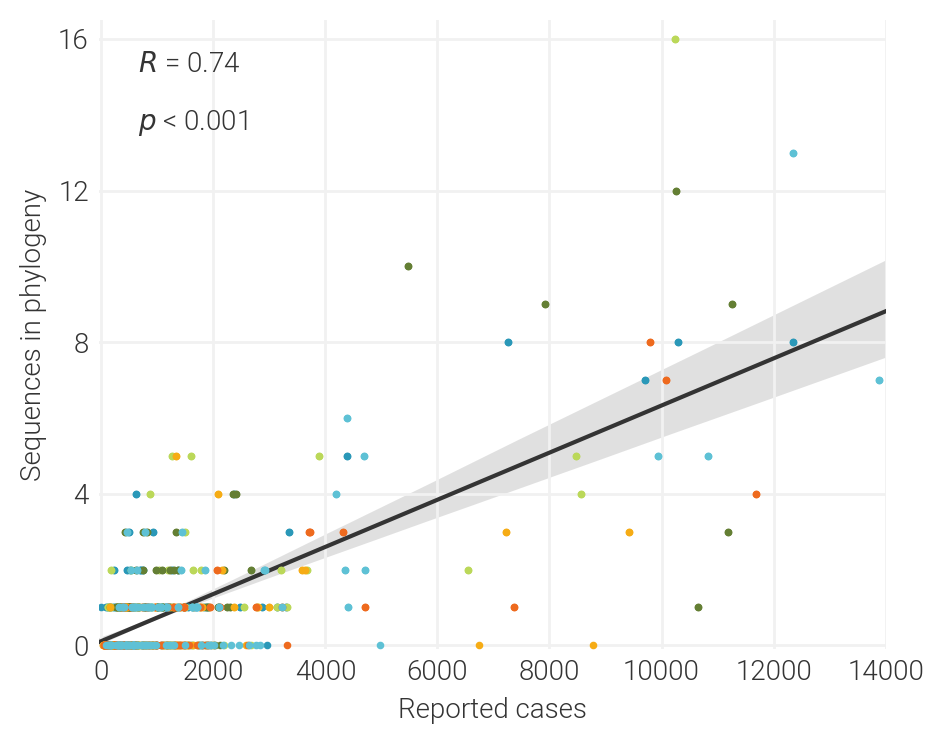

In [38]:
reg_colors = {
    "Central" : "#2a98b8",
    "East" : "#bbd859",
    "North Central" : "#647f34",
    "North Coastal" : "#f6ac15",
    "North Inland" : "#ee6a1e",
    "South" : "#5ec1d5",
}

fig, ax = plt.subplots( dpi=200, figsize=(5,4) )

for reg in reg_colors.keys():
    temp = comparison.loc[reg]
    ax.scatter( x=temp["new_cases"], y=temp["sequences"], color=reg_colors[reg], s=3, zorder=10 )
sns.regplot( x=comparison["new_cases"], y=comparison["sequences"], color=COLOR, scatter=False, line_kws={"zorder" : 5, "linewidth" : 1.5}, ax=ax, truncate=False )

basic_formatting( ax, spines=[], which="both", xlims=(-50,14000), ylims=(-0.1,16.5), ylabel="Sequences in phylogeny", xlabel="Reported cases", xsize=10, ysize=10)
ax.tick_params( axis="x", rotation=0 )

result = pearsonr( comparison["new_cases"], comparison["sequences"] )
print( result )

print( f"(Pearson r = {result.statistic:.2f} [95% CI: {result.confidence_interval().low:.2f}-{result.confidence_interval().high:.2f}]" )
ax.text( 0.05, 0.95, f"$R$ = {result.statistic:.2f}", transform=ax.transAxes, fontsize=10, ha="left", va="top" )
if result.pvalue < 0.001:
    print( "p < 0.001" )
    ax.text( 0.05, 0.86, f"$p$ < 0.001", transform=ax.transAxes, fontsize=10, ha="left", va="top" )
else:
    print( "{result.pvalue:.2f}" )
    ax.text( 0.05, 0.86, f"$p$ = {result.pvalue:.2f}", transform=ax.transAxes, fontsize=10, ha="left", va="top" )
ax.set_yticks([0,4,8,12,16])

plt.tight_layout()
plt.savefig( "../analyses/plots/figureSX_sampling-per-region.pdf" )
plt.show()